# MovieLens Dataset - Exploratory Data Analysis

## 1. Dataset Overview
This section provides an overview of the MovieLens dataset, including scale and structure.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
movies = pd.read_csv("../data/ml-latest/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings = pd.read_csv("../data/ml-latest/ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [5]:
tags = pd.read_csv("../data/ml-latest/tags.csv")
tags.head()

,userId,movieId,tag,timestamp
0,10,260,good vs evil,1430666558
1,10,260,Harrison Ford,1430666505
2,10,260,sci-fi,1430666538
3,14,1221,Al Pacino,1311600756
4,14,1221,mafia,1311600746


In [6]:
n_users = ratings["userId"].nunique()
n_movies = ratings["movieId"].nunique()
n_ratings = len(ratings)

print(f"Users: {n_users:,}")
print(f"Movies: {n_movies:,}")
print(f"Ratings: {n_ratings:,}")

Users: 330,975
Movies: 83,239
Ratings: 33,832,162


In [7]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33832162 entries, 0 to 33832161
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 1.0 GB


### Dataset Description

The MovieLens dataset contains **33.8 million explicit user–movie interactions** with no missing values.  
Each interaction includes a numeric rating (0.5–5.0) and a timestamp.

**Files used:**
- `movies.csv`: Movie metadata including title and genres
- `ratings.csv`: User ratings with timestamps
- `tags.csv`: User-generated tags describing movies

This level of sparsity and scale motivates the use of matrix factorization, which operates on latent representations rather than a dense user-item matrix.

## 2. Ratings Distribution
We analyze how users assign ratings and whether the data is skewed.

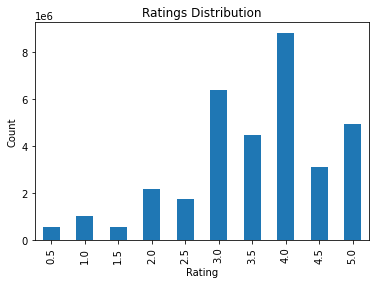

In [8]:
ratings["rating"].value_counts().sort_index().plot(kind="bar")
plt.title("Ratings Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

### Ratings Distribution Insights

The ratings are skewed toward higher values, with **4.0 being the most common rating**.  
Lower ratings (0.5–1.5) are relatively rare, indicating a **positivity bias** in the data.

This distribution suggests:
- Popularity-based recommenders may over-recommend highly rated movies.
- Matrix factorization (SVD) is appropriate to learn **latent user preferences**, capturing subtle taste signals beyond obvious high-rated movies.
- Metrics like **Precision@K** are essential in addition to RMSE, since ranking quality matters more than predicting exact ratings.


## 3. User Activity Analysis
This section explores how active users are in providing ratings.

In [9]:
# Compute number of ratings per user
user_activity = ratings.groupby("userId").size()
user_activity.head()

userId
1    62
2    91
3    30
4    30
5    43
dtype: int64

In [10]:
print(user_activity.describe())

count    330975.00000
mean        102.21969
std         232.15453
min           1.00000
25%          15.00000
50%          31.00000
75%          98.00000
max       33332.00000
dtype: float64


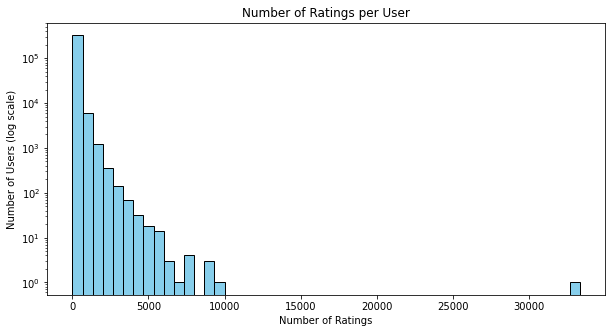

In [11]:
plt.figure(figsize=(10,5))
plt.hist(user_activity, bins=50, color='skyblue', edgecolor='black')
plt.yscale('log') 
plt.title("Number of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users (log scale)")
plt.show()

### User Activity Analysis

Most users provide relatively few ratings, while a small number of users are extremely active (power users).
This long-tail distribution suggests:

- We may need to filter out users with very few ratings to reduce noise.  
- Sparse data will make popularity-based recommendations biased toward movies rated by power users.  
- Matrix factorization will benefit from more active users, as it has more data to learn latent preferences.

**Next steps:** We will decide a minimum number of ratings per user when preprocessing to balance coverage and model quality.

## 4. Movie Popularity Analysis
We examine the long-tail distribution of movie ratings.

In [12]:
# Compute number of ratings per movie
movie_popularity = ratings.groupby("movieId").size()
movie_popularity.head()

movieId
1    76813
2    30209
3    15820
4     3028
5    15801
dtype: int64

In [13]:
print(movie_popularity.describe())

count     83239.000000
mean        406.446041
std        2806.975876
min           1.000000
25%           2.000000
50%           5.000000
75%          26.000000
max      122296.000000
dtype: float64


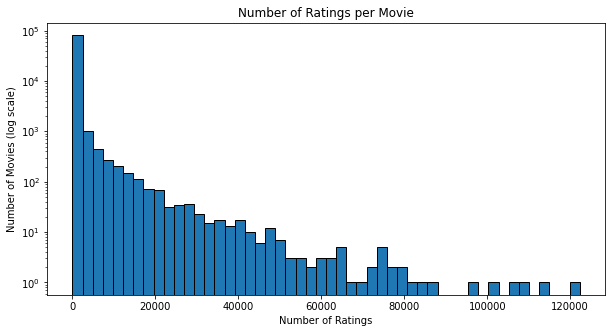

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(movie_popularity, bins=50, edgecolor='black')
plt.yscale("log")
plt.title("Number of Ratings per Movie")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies (log scale)")
plt.show()

### Movie Popularity Analysis

Movie ratings follow a strong **long-tail distribution**, where a small number of popular movies receive a large share of all ratings, while most movies are rated infrequently, hence the reason for using a logarithmic scale.

This has important implications:
- Popularity-based recommenders tend to over-recommend a small set of widely rated movies.
- Niche movies with few ratings are underrepresented despite potential relevance to specific users.
- Matrix factorization can mitigate this bias by learning latent factors that generalize user preferences beyond highly rated movies.


## 5. Sparsity & Implications
We quantify matrix sparsity and discuss its impact on model choice.

In [15]:
n_users = ratings["userId"].nunique()
n_movies = ratings["movieId"].nunique()
n_ratings = len(ratings)

total_possible = n_users * n_movies
sparsity = 1 - (n_ratings / total_possible)

print(f"Sparsity: {sparsity:.4%}")

Sparsity: 99.8772%


### Sparsity & Implications

The user–movie interaction matrix in the MovieLens dataset is extremely sparse. With over 33 million observed ratings across tens of thousands of users and movies, approximately **99.88%** of all possible user–movie pairs are missing.

This high level of sparsity makes traditional similarity-based approaches challenging, as most users share very few commonly rated movies. Matrix factorization addresses this issue by learning low-dimensional latent representations of users and items, enabling meaningful recommendations even when direct rating overlap is limited.

These characteristics motivate the use of an SVD-based collaborative filtering approach over simpler popularity-based methods.
